In [87]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from itertools import product as outer
import scipy.stats as stats

%matplotlib inline
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

# Load Data

In [3]:
bed = pd.read_csv("peaks.single.partial.bed6", sep="\t", 
                  header=None, names=["chromosome", "start", "stop", "gene", "score", "strand"],
                  dtype={'chromosome': 'category', 'gene': 'category', 'strand': 'category'})
bed['txEnd'] = bed.apply(lambda df: df.stop if df.strand == '+' else df.start, axis=1)
bed['width'] = np.abs(bed.start - bed.stop)
bed.head()

chromosome      start       stop     gene  score strand      txEnd  width
0       chr1   10137565   10138306  Arfgef1      0      -   10137565    741
1       chr1   54987021   54987497    Sf3b1      0      -   54987021    476
2       chr1  171340791  171341636     Dedd      0      +  171341636    845
3      chr10   52337021   52338132     Gopc      0      -   52337021   1111
4      chr10   77597639   77598741  Pttg1ip      0      +   77598741   1102

### Previously saved joined table

In [5]:
data = pd.read_table("tmuris.coverage.partial.tsv.gz")
data.head()

chromosome  position  counts       batch           gene     txEnd  width  \
0       chr2  91278316       1  SRR6835844  1110051M20Rik  91278241    711   
1       chr2  91278318       1  SRR6835844  1110051M20Rik  91278241    711   
2       chr2  91278323       1  SRR6835844  1110051M20Rik  91278241    711   
3       chr2  91278324       1  SRR6835844  1110051M20Rik  91278241    711   
4       chr2  91278328       1  SRR6835844  1110051M20Rik  91278241    711   

   distance  
0        75  
1        77  
2        82  
3        83  
4        87

In [6]:
data.batch.unique()

array(['SRR6835844', 'SRR6835845', 'SRR6835846', 'SRR6835847',
       'SRR6835848', 'SRR6835849', 'SRR6835850', 'SRR6835851',
       'SRR6835852', 'SRR6835853', 'SRR6835854', 'SRR6835855',
       'SRR6835856', 'SRR6835857', 'SRR6835858', 'SRR6835859',
       'SRR6835860', 'SRR6835861', 'SRR6835862', 'SRR6835863',
       'SRR6835864', 'SRR6835865', 'SRR6835866', 'SRR6835867',
       'SRR6835868', 'SRR6835869', 'SRR6835870', 'SRR6835871'],
      dtype=object)

In [9]:
data.gene.unique()

array(['1110051M20Rik', 'Acaca', 'Agl', 'Aplp2', 'Arfgef1', 'Asb6',
       'BC037034', 'Bcas3', 'Bcl2l1', 'C2cd2l', 'Calm3', 'Ccdc92',
       'Cd151', 'Cd2bp2', 'Chd3', 'Chmp3', 'Clip2', 'Cog6', 'Cstf1',
       'Dedd', 'Dnm2', 'Dpm2', 'Entpd6', 'Eral1', 'Fam193a', 'Fbxw8',
       'Fitm2', 'Fnip1', 'Gabarapl1', 'Gnb1', 'Golga2', 'Gopc', 'Hadh',
       'Kat7', 'Kxd1', 'Lrpap1', 'Lrrc59', 'Lyrm2', 'Map1lc3b', 'Mau2',
       'Metap1', 'Mllt11', 'Nab2', 'Nckap1', 'Ncln', 'Ncor2', 'Ndrg3',
       'Ntmt1', 'Otud4', 'Pcbp4', 'Pgap2', 'Pgd', 'Prosc', 'Ptges2',
       'Pttg1ip', 'Pxn', 'Rapgef6', 'Rbm39', 'Rusc2', 'Sec61a1', 'Sep15',
       'Sf3b1', 'Sh2b1', 'Sh2b3', 'Snapc2', 'Snx21', 'Srpk2', 'Stard7',
       'Tbc1d10a', 'Tmed1', 'Tmub1', 'Tmx2', 'Traf2', 'Trappc3', 'Ttbk2',
       'Ube2z', 'Ube3b', 'Ubqln4', 'Vamp2', 'Vamp3', 'Vps9d1', 'Wdr5',
       'Ywhah', 'Zfp444', 'Zfp64'], dtype=object)

# Plot some raw data

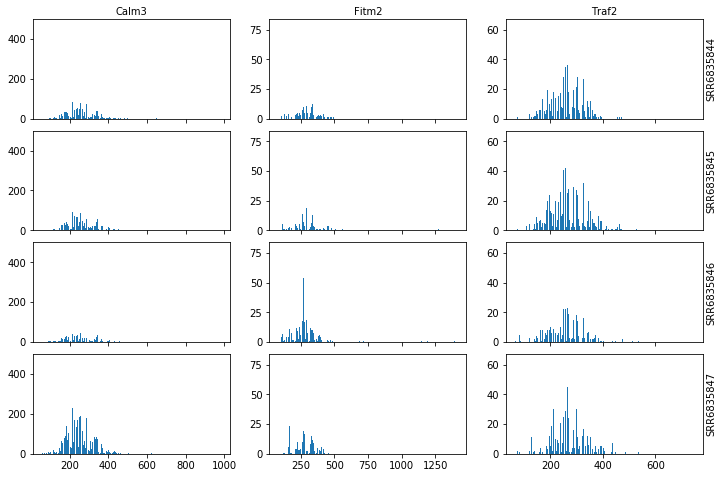

In [10]:
genes = ['Calm3', 'Fitm2', 'Traf2']
batches = ['SRR6835844', 'SRR6835845', 'SRR6835846', 'SRR6835847']
B, G = len(batches), len(genes)

f, axs = plt.subplots(B, G, figsize=(12, 8), sharex='col', sharey='col')
for (i,j) in outer(range(B), range(G)):
    b, g = batches[i], genes[j]
    d_gb = data.loc[(data.gene == g) & (data.batch == b), :]
    axs[i, j].bar(x=d_gb.distance, height=d_gb.counts)
    if i == 0:
        axs[i,j].set(xlabel=g)
        axs[i,j].xaxis.set_label_position("top")

    if j == G - 1:
        axs[i,j].set(ylabel=b)
        axs[i,j].yaxis.set_label_position("right")
        

f.subplots_adjust(hspace=0.12)
plt.show()

# Aggregate Data

In [34]:
data_agg = data.groupby(['batch', 'distance']).agg({'counts': 'sum'}).reset_index()

X = pd.get_dummies(data_agg.batch)
Y = data_agg.distance.values
W = data_agg.counts.values

data_agg.head()

batch  distance  counts
0  SRR6835844        59       3
1  SRR6835844        60       1
2  SRR6835844        61       9
3  SRR6835844        62       6
4  SRR6835844        63      23

## Plot raw aggregated data

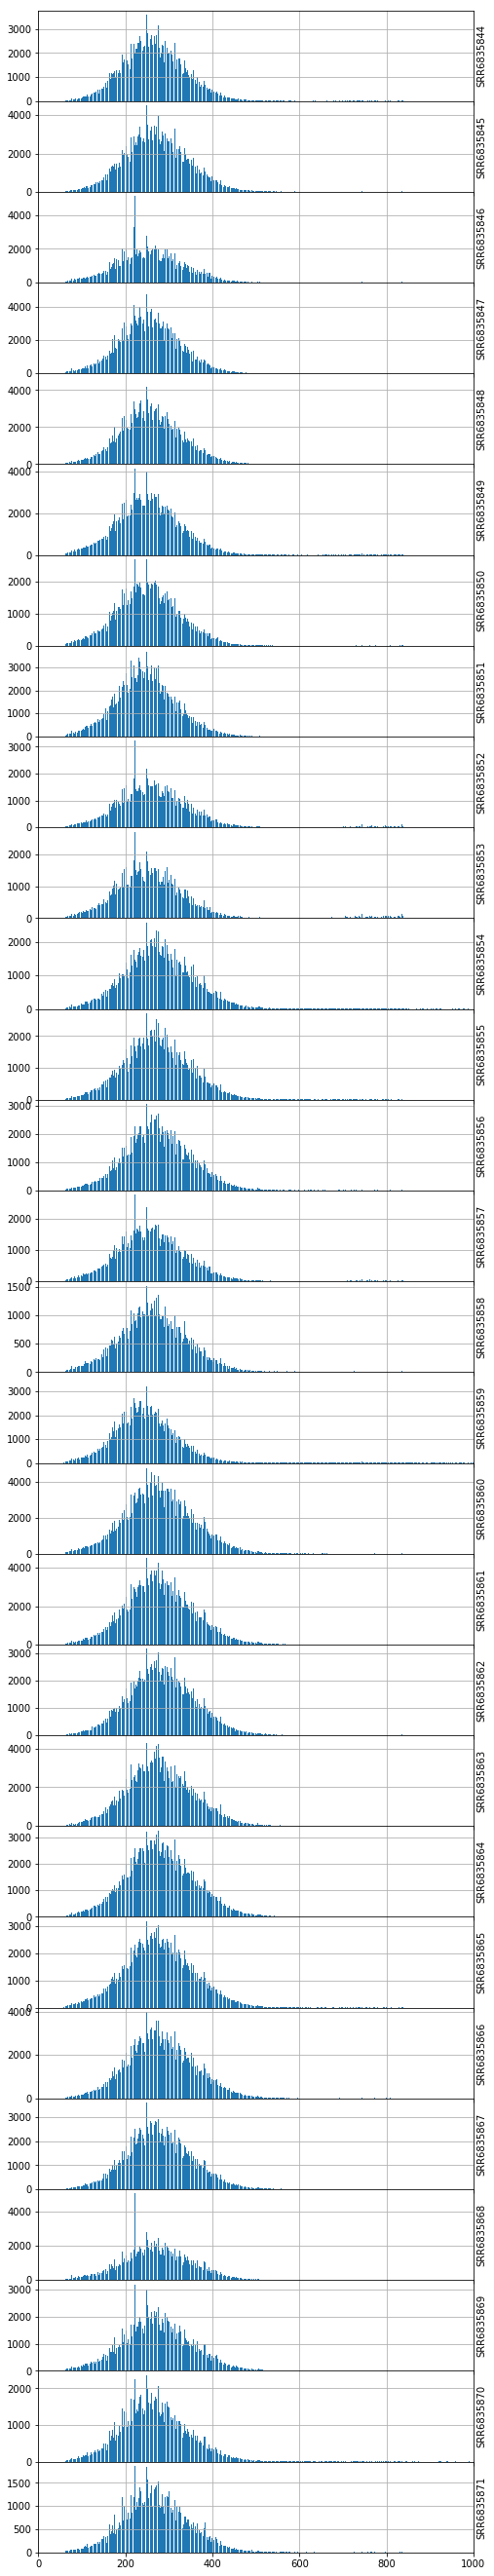

In [125]:
B = data_agg.batch.nunique()

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col')
axs[0].set_xlim(left=0, right=1000)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts)
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()

# Modeling
NUTS is having trouble getting started, so we will start with a medium length Metropolis-Hastings run to get an initial picture of what could be bottlenecking the process.

In [41]:
with pm.Model() as m1:
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X.shape[1])
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X.shape[1])
    
    sigma = sigma_all + pm.math.dot(X, alpha)
    mu = mu_all + pm.math.dot(X, beta)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    trace_m1 = pm.sample(100000, tune=100000, chains=4, cores=4, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [mu_all]
>Metropolis: [alpha]
>Metropolis: [sigma_all]
Sampling 4 chains: 100%|██████████| 800000/800000 [2:43:20<00:00, 81.62draws/s]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [42]:
pm.summary(trace_m1)

mean        sd  mc_error     hpd_2.5    hpd_97.5       n_eff  \
sigma_all   78.005375  0.238469  0.023371   77.684745   78.517919    2.947108   
mu_all     272.811428  0.188716  0.015641  272.454844  273.186261   60.904077   
beta__0     -3.577957  0.251455  0.020178   -4.073959   -3.092827   14.696655   
beta__1      2.064181  0.395824  0.036698    1.141318    2.631326    4.664690   
beta__2    -10.108725  0.233038  0.015559  -10.569238   -9.655178   95.931885   
beta__3    -13.388626  0.242289  0.019870  -13.861670  -12.900410   15.505565   
beta__4     -9.922585  0.262250  0.021732  -10.442176   -9.413143    9.551332   
beta__5    -13.525522  0.220432  0.015850  -13.964594  -13.097482   79.149626   
beta__6    -14.189498  0.231270  0.015982  -14.650599  -13.755106   89.734501   
beta__7    -20.412357  0.248567  0.020158  -20.902390  -19.926675   14.131910   
beta__8      2.107970  0.248680  0.015612    1.620048    2.597892  108.378896   
beta__9     -2.970621  0.254311  0.015618   -3.468059   -2.467272  118.161669   
beta__10     8.561241  0.239623  0.016171    8.094244    9.023193   99.613381   
beta__11     6.366897  0.237198  0.016062    5.904536    6.832048   96.202496   
beta__12     8.693187  0.232432  0.016166    8.230520    9.142399   86.409993   
beta__13    -3.671615  0.244332  0.015692   -4.151077   -3.203616  106.149045   
beta__14     0.037697  0.266404  0.016106   -0.491598    0.553263  124.680882   
beta__15   -19.042981  0.229600  0.016130  -19.504033  -18.612262   80.549118   
beta__16     8.723152  0.212560  0.015634    8.323591    9.146963   78.167945   
beta__17     8.654741  0.211249  0.015478    8.250761    9.067836   81.440219   
beta__18    12.938076  0.224328  0.015796   12.491835   13.366395   83.610145   
beta__19     9.385804  0.215913  0.015681    8.966963    9.805466   79.796323   
beta__20    10.268680  0.218408  0.015529    9.841092   10.688289   80.893735   
beta__21     7.753528  0.223563  0.015781    7.312626    8.183808   88.151293   
beta__22    11.943655  0.221780  0.016147   11.514299   12.380745   79.763157   
beta__23     8.447922  0.221832  0.016002    8.021351    8.878166   81.787286   
beta__24     2.501915  0.229587  0.015587    2.052846    2.952655   94.043906   
beta__25     3.159172  0.230413  0.015649    2.717947    3.611684   99.717088   
beta__26    -2.031026  0.239502  0.015806   -2.503570   -1.578649  101.422940   
beta__27     1.158030  0.246341  0.015335    0.667688    1.619867  105.776957   
alpha__0     0.019328  0.023307  0.002324    0.000697    0.081178    5.758376   
alpha__1     2.002125  0.881568  0.087540    0.015515    2.652668    3.488416   
alpha__2     7.678243  0.258260  0.022982    7.105021    8.089166    3.552329   
alpha__3     0.010889  0.008503  0.000846    0.000824    0.028302    2.311060   
alpha__4     0.239477  0.399892  0.039887    0.003707    1.006141    2.033024   
alpha__5     3.971444  0.251875  0.023255    3.403471    4.353599    3.314140   
alpha__6     3.783599  0.262514  0.023799    3.205274    4.189229    3.862228   
alpha__7     0.010862  0.006590  0.000654    0.002487    0.024909    4.534742   
alpha__8    18.919767  0.269581  0.022919   18.321870   19.368826    3.774537   
alpha__9    21.413273  0.276220  0.023226   20.800783   21.874513    3.833820   
alpha__10   10.395651  0.259828  0.023007    9.817897   10.821179    3.506168   
alpha__11    9.693519  0.261481  0.023340    9.109901   10.115961    3.472407   
alpha__12   10.412163  0.255629  0.022944    9.837947   10.807186    3.473676   
alpha__13   13.198363  0.266148  0.023069   12.602047   13.629838    3.663179   
alpha__14   11.832297  0.278220  0.023059   11.230862   12.310542    4.146248   
alpha__15    4.355915  0.255240  0.023135    3.785103    4.765430    3.464875   
alpha__16    7.853955  0.251002  0.023420    7.302962    8.238365    3.238792   
alpha__17    5.730034  0.255846  0.023445    5.167919    6.113602    3.450026   
alpha__18    6.195417  0.255848  0.023365    5.6

Worth noting here is that the posterior scale on most variables is on the same order of magnitude.  However, the number of effective samples is quite poor, with the split $\hat{R}$ indicating lack of aggreement across chains.

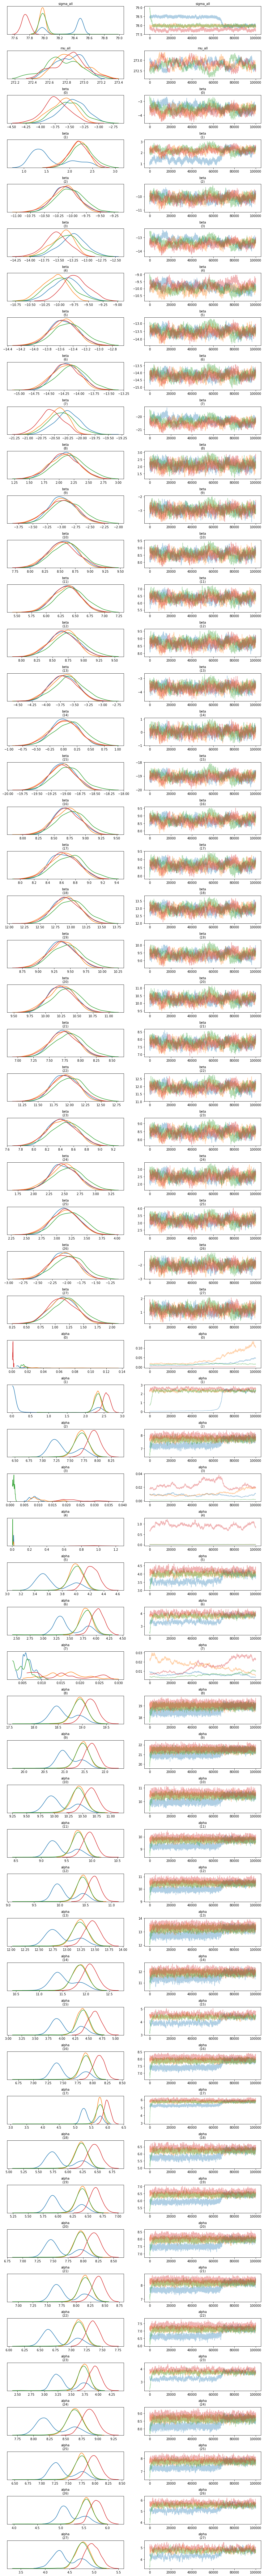

In [43]:
az.plot_trace(trace_m1)
plt.show()

We can clearly see one of the chains appeared trapped in a location that differed strongly from the other chains. For this reason, it seems justified to regard all the data up to that switch to be *burn-in*.  Let's truncate the data there, compute new means, and then start a new run initialized to the means.

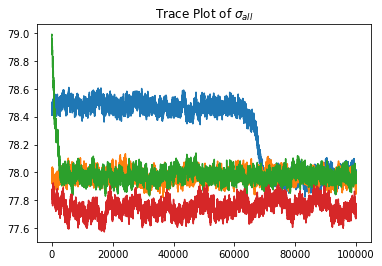

In [110]:
# just checking that the reshaping order I use recapitulates the trace above
plt.plot(trace_m1['sigma_all'].reshape((100000,4), order='F'))
plt.title("Trace Plot of $\sigma_{all}$")
plt.show()

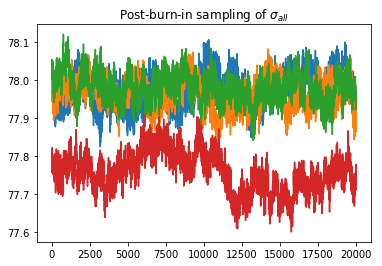

In [95]:
plt.plot(trace_m1['sigma_all'].reshape((100000,4), order='F')[80000:,:])
plt.title("Post-burn-in sampling of $\sigma_{all}$")
plt.show()

### Extracting mean values using iterations 80K-100K

In [84]:
alpha_hat = trace_m1.get_values('alpha', combine=True).reshape((100000,4,28), order='F')[80000:,:,:].mean(axis=(0,1))
beta_hat = trace_m1.get_values('beta', combine=True).reshape((100000,4,28), order='F')[80000:,:,:].mean(axis=(0,1))
mu_all_hat = trace_m1['mu_all'].reshape((100000,4), order='F')[80000:,:].mean()
sigma_all_hat = trace_m1['sigma_all'].reshape((100000,4), order='F')[80000:,:].mean()

## Plot data with fitted distributions

In [85]:
def gamma_reparam(mu, sd):
    """
    Conversion method for parameterizing `scipy.stats.gamma` using mean and standard deviation.
    """
    a = mu**2/sd**2
    scale = sd**2/mu
    
    return a, scale

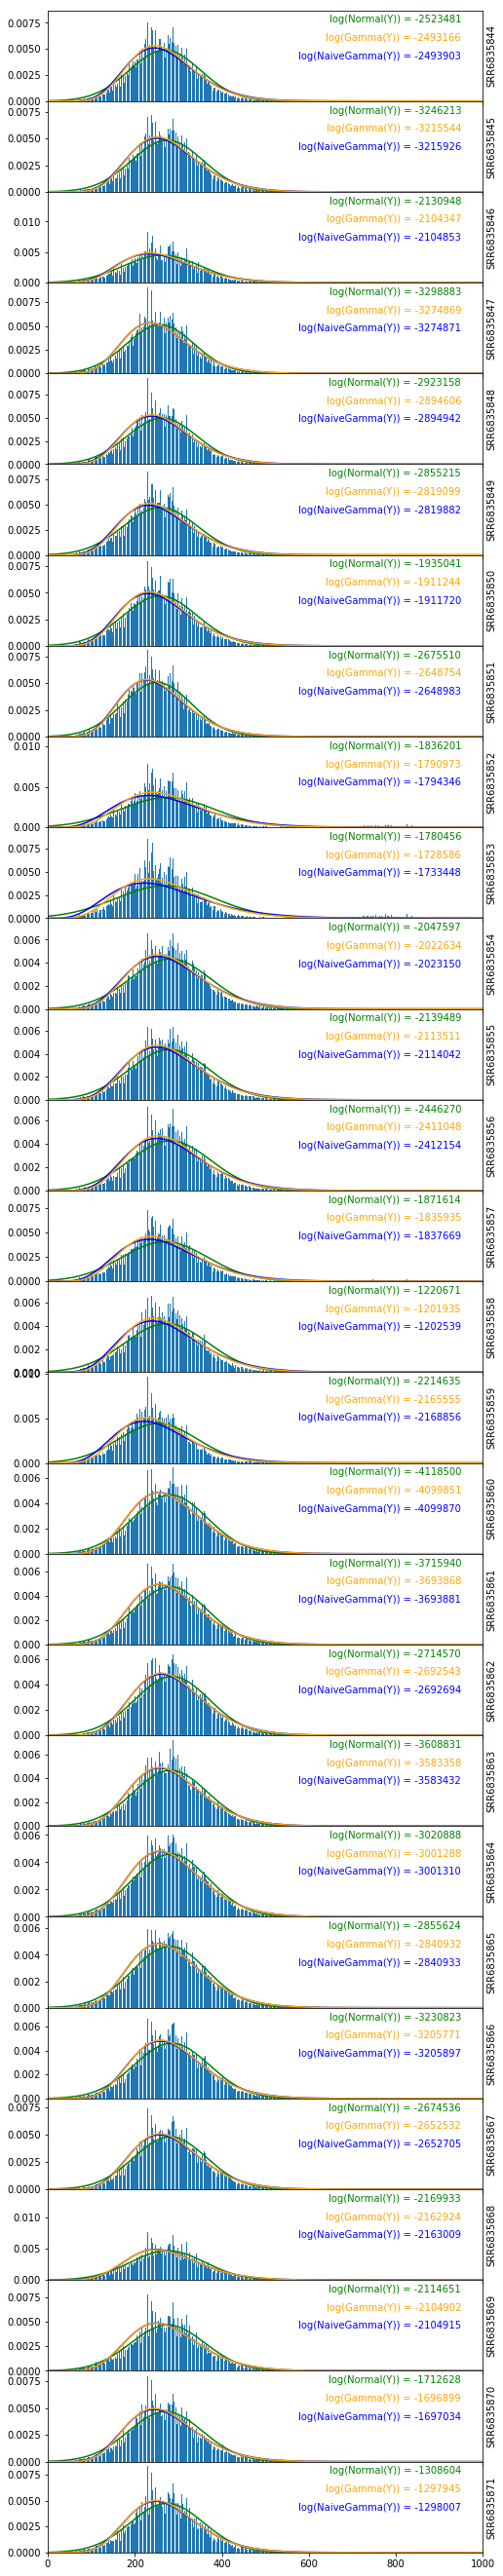

In [103]:
B = data_agg.batch.nunique()
X_plt = np.linspace(0,1000, 200)

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col')
axs[0].set_xlim(left=0, right=1000)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts/d_b.counts.sum())
    
    # Fitted Normal
    mu_raw = d_b.distance.dot(d_b.counts)/d_b.counts.sum()
    sd_raw = np.sqrt(d_b.counts.dot((d_b.distance - mu_raw)**2) / (d_b.counts.sum() - 1))
    Y_plt = stats.norm(loc=mu_raw, scale=sd_raw).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='green')
    
    loglik_norm = d_b.counts.dot(stats.norm(loc=mu_raw, scale=sd_raw).logpdf(d_b.distance))
    axs[i].text(0.95, 0.95, "log(Normal(Y)) = %d" % loglik_norm, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='green')
    
    # Naive Fitted Gamma
    a, scale = gamma_reparam(mu_raw, sd_raw)
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='blue')
    
    loglik_gamma2 = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.55, "log(NaiveGamma(Y)) = %d" % loglik_gamma2, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='blue')
    
    # Fitted Gamma
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat + alpha_hat[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='orange')
    
    loglik_gamma = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.75, "log(Gamma(Y)) = %d" % loglik_gamma, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes, color='orange')
    
    # 95% cutoff
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()

It appears the posterior gammas perform the best. However, it should be noted the other fits are using summary stats and not MLE distributions.

# Rerun from Previous Mean Positions

In [109]:
start_vals={'alpha': alpha_hat, 'beta': beta_hat, 'mu_all': mu_all_hat, 'sigma_all': sigma_all_hat}

with pm.Model() as m1_continued:
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    alpha = pm.HalfNormal('alpha', sd=1, shape=X.shape[1])
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=X.shape[1])
    
    sigma = sigma_all + pm.math.dot(X, alpha)
    mu = mu_all + pm.math.dot(X, beta)
    
    y = pm.Potential('y_logp_weighted', W*pm.Gamma.dist(mu=mu, sd=sigma).logp(Y))
    
    trace_m1_continued = pm.sample(10000, tune=10000, chains=4, cores=4, start=start_vals)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu_all, alpha, sigma_all]
Sampling 4 chains: 100%|██████████| 80000/80000 [2:11:56<00:00,  6.53draws/s]  
The acceptance probability does not match the target. It is 0.899846842772182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815755338359474, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [111]:
pm.summary(trace_m1_continued)

mean        sd  mc_error       hpd_2.5    hpd_97.5  \
sigma_all   77.603272  0.057836  0.000770  7.748845e+01   77.714919   
mu_all     272.802217  0.189792  0.003631  2.724293e+02  273.170558   
beta__0     -3.523257  0.221658  0.003756 -3.964083e+00   -3.097275   
beta__1      2.224389  0.215784  0.003714  1.811293e+00    2.652525   
beta__2    -10.099935  0.234032  0.003672 -1.055411e+01   -9.643837   
beta__3    -13.588007  0.212353  0.003629 -1.399395e+01  -13.166541   
beta__4     -9.695496  0.217630  0.003671 -1.012996e+01   -9.277213   
beta__5    -13.513355  0.220836  0.003671 -1.394699e+01  -13.086366   
beta__6    -14.186274  0.234606  0.003716 -1.464254e+01  -13.729378   
beta__7    -20.615300  0.216087  0.003629 -2.104185e+01  -20.196570   
beta__8      2.120604  0.252899  0.003705  1.642021e+00    2.633158   
beta__9     -2.966060  0.257547  0.003615 -3.468999e+00   -2.461404   
beta__10     8.561103  0.238488  0.003635  8.102337e+00    9.030179   
beta__11     6.372485  0.235457  0.003743  5.911265e+00    6.830501   
beta__12     8.700231  0.231795  0.003538  8.251083e+00    9.153921   
beta__13    -3.667727  0.246017  0.003691 -4.147679e+00   -3.188448   
beta__14     0.054712  0.266062  0.003716 -4.758067e-01    0.566294   
beta__15   -19.039964  0.229582  0.003662 -1.948567e+01  -18.582599   
beta__16     8.731254  0.213591  0.003631  8.309444e+00    9.144685   
beta__17     8.661987  0.214295  0.003628  8.236523e+00    9.070603   
beta__18    12.948176  0.224255  0.003738  1.252073e+01   13.397611   
beta__19     9.393908  0.216161  0.003711  8.968474e+00    9.809343   
beta__20    10.273403  0.221676  0.003645  9.836768e+00   10.702296   
beta__21     7.758104  0.224148  0.003706  7.317739e+00    8.192950   
beta__22    11.953728  0.218766  0.003623  1.153024e+01   12.384891   
beta__23     8.456985  0.222351  0.003547  8.021617e+00    8.890157   
beta__24     2.510732  0.233264  0.003747  2.060924e+00    2.969603   
beta__25     3.165099  0.234886  0.003745  2.707941e+00    3.621265   
beta__26    -2.027036  0.239877  0.003586 -2.506230e+00   -1.568910   
beta__27     1.171453  0.251932  0.003592  6.791249e-01    1.668897   
alpha__0     0.520271  0.105715  0.000883  3.176009e-01    0.730318   
alpha__1     2.703484  0.100074  0.000867  2.503441e+00    2.895089   
alpha__2     8.076742  0.122990  0.001095  7.836410e+00    8.316607   
alpha__3     0.009501  0.009449  0.000041  3.133447e-08    0.028181   
alpha__4     1.063674  0.102333  0.000898  8.582167e-01    1.259171   
alpha__5     4.375185  0.106364  0.000862  4.165799e+00    4.582609   
alpha__6     4.178218  0.122075  0.000950  3.938458e+00    4.414866   
alpha__7     0.009586  0.009486  0.000052  3.717910e-07    0.028577   
alpha__8    19.319464  0.146922  0.001121  1.903910e+01   19.613649   
alpha__9    21.808648  0.152560  0.001175  2.151460e+01   22.114123   
alpha__10   10.792101  0.127056  0.001014  1.054494e+01   11.042852   
alpha__11   10.089997  0.123252  0.000968  9.844234e+00   10.329027   
alpha__12   10.808458  0.119281  0.000946  1.058416e+01   11.052570   
alpha__13   13.594012  0.137550  0.000928  1.332972e+01   13.865929   
alpha__14   12.235719  0.159816  0.001244  1.191903e+01   12.546550   
alpha__15    4.751656  0.117944  0.001029  4.521460e+00    4.984417   
alpha__16    8.255185  0.096632  0.000958  8.065541e+00    8.443874   
alpha__17    6.130727  0.097581  0.000890  5.933659e+00    6.315579   
alpha__18    6.596490  0.110119  0.000955  6.379006e+00    6.808120   
alpha__19    6.772610  0.100061  0.000951  6.581371e+00    6.971019   
alpha__20    8.322376  0.106119  0.000908  8.115776e+00    8.529749   
alpha__21    8.525973  0.109215  0.000857  8.318645e+00    8.747419   
alpha__22    7.492324  0.103556  0.000931  7.291936e+00    7.698342   
alpha__23    4.094064  0.107574  0.000930  3.883249e+00    4.306581   
alpha__24    9.011649  0.121925  0.000879  8.777831e+00    9.255544   
alpha__25    8.114468  0.122084  0.000981

Despite the complaints about effective sample size, the overall sampling looks significantly improved compared to previously. All values appear converged.

### Alpha values

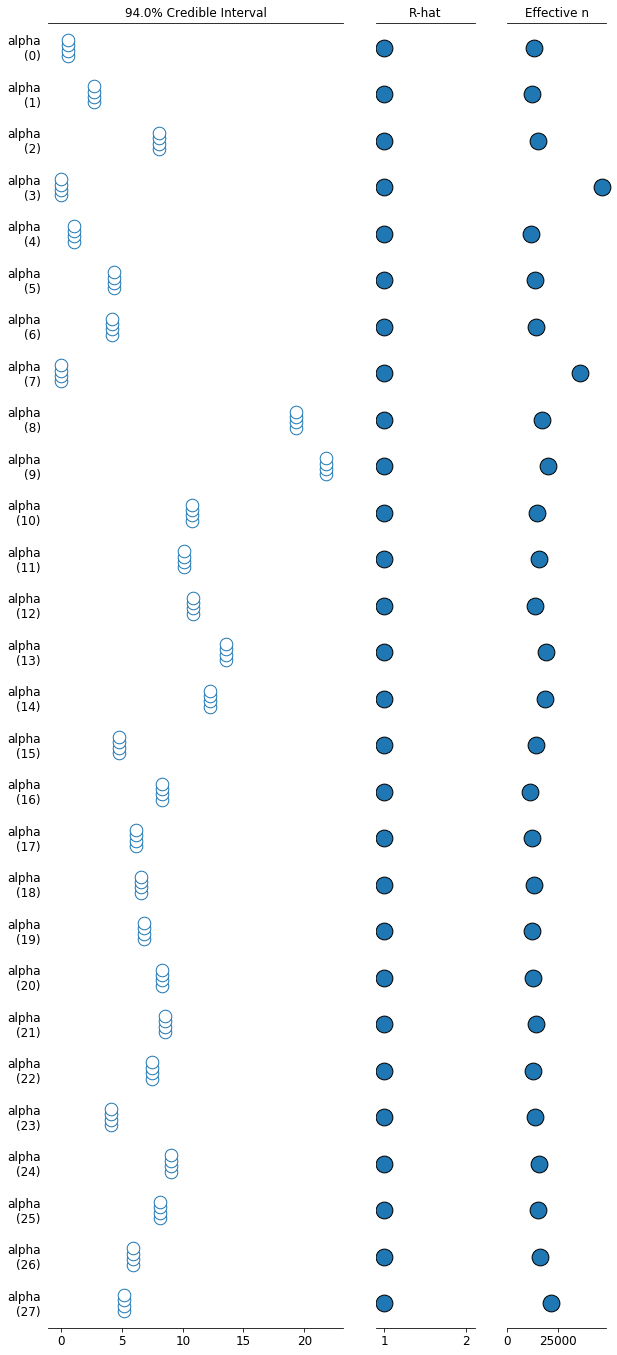

In [133]:
az.plot_forest(trace_m1_continued, var_names=['alpha'], figsize=(10,24), textsize=12)
plt.show()

### Beta values

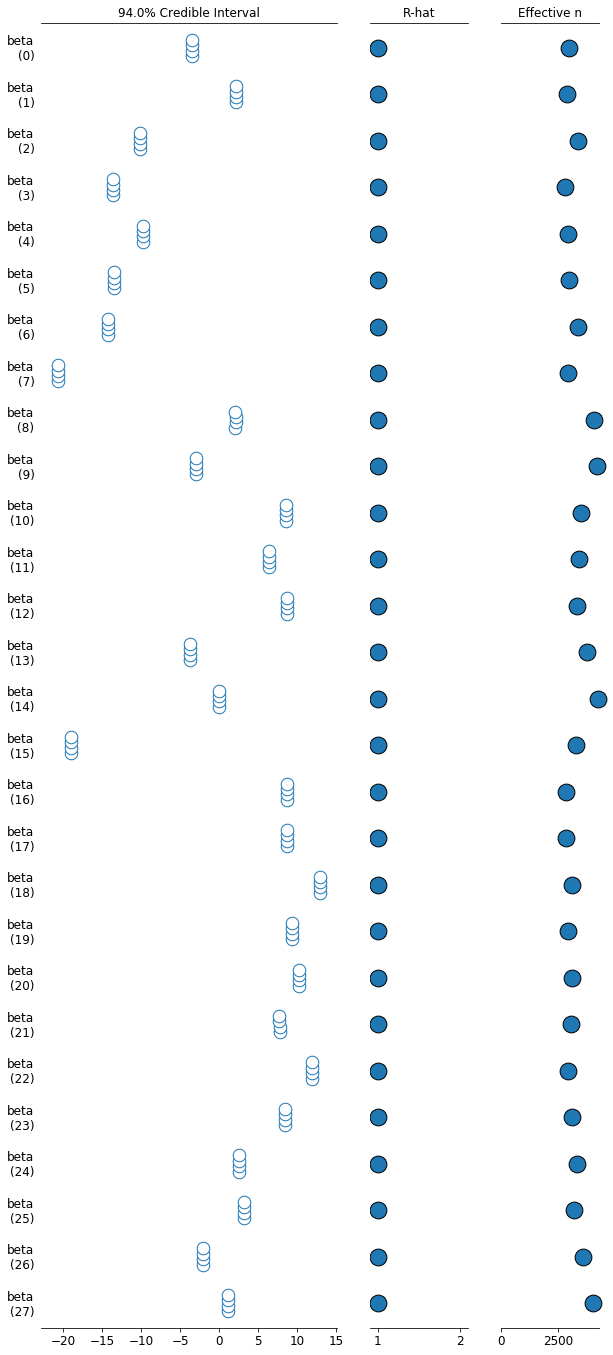

In [134]:
az.plot_forest(trace_m1_continued, var_names=['beta'], figsize=(10,24), textsize=12)
plt.show()

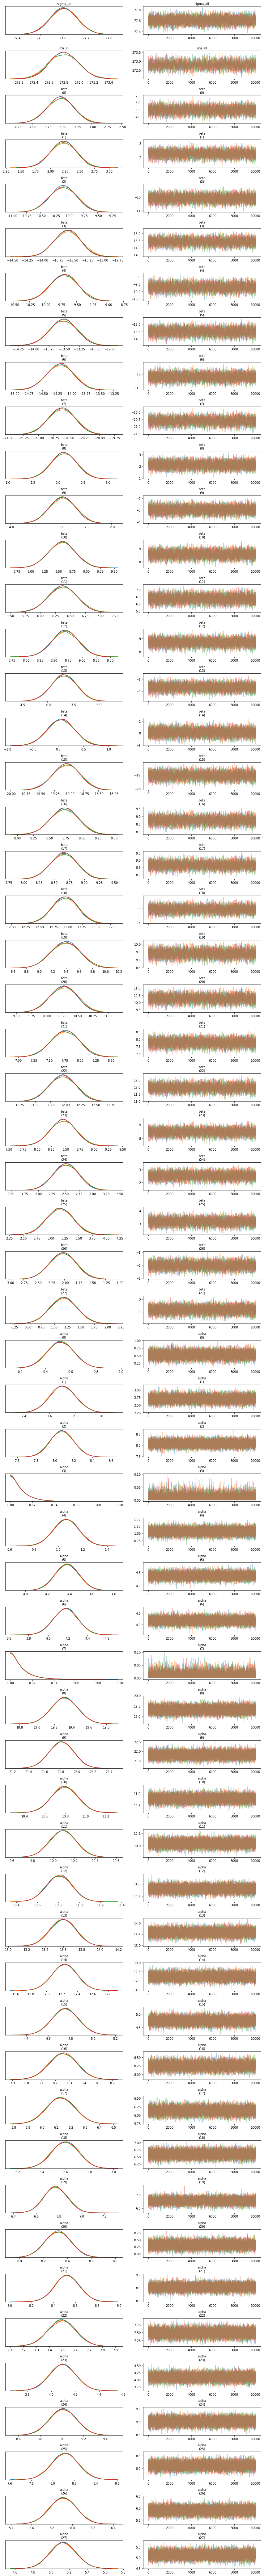

In [114]:
az.plot_trace(trace_m1_continued)
plt.show()

### Posteriors for intercept parameters

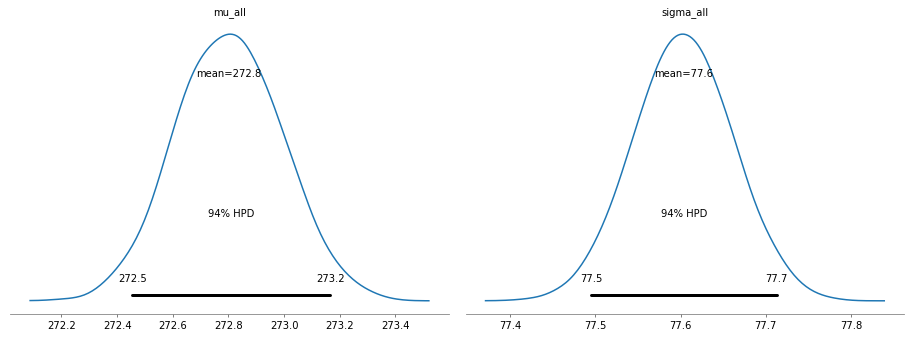

In [115]:
az.plot_posterior(trace_m1_continued, var_names=['mu_all', 'sigma_all'])
plt.show()

## Plot fitted distributions

In [135]:
alpha_hat_full = trace_m1_continued.get_values('alpha').mean(axis=0)
beta_hat_full = trace_m1_continued.get_values('beta').mean(axis=0)
mu_all_hat_full = trace_m1_continued['mu_all'].mean()
sigma_all_hat_full = trace_m1_continued['sigma_all'].mean()

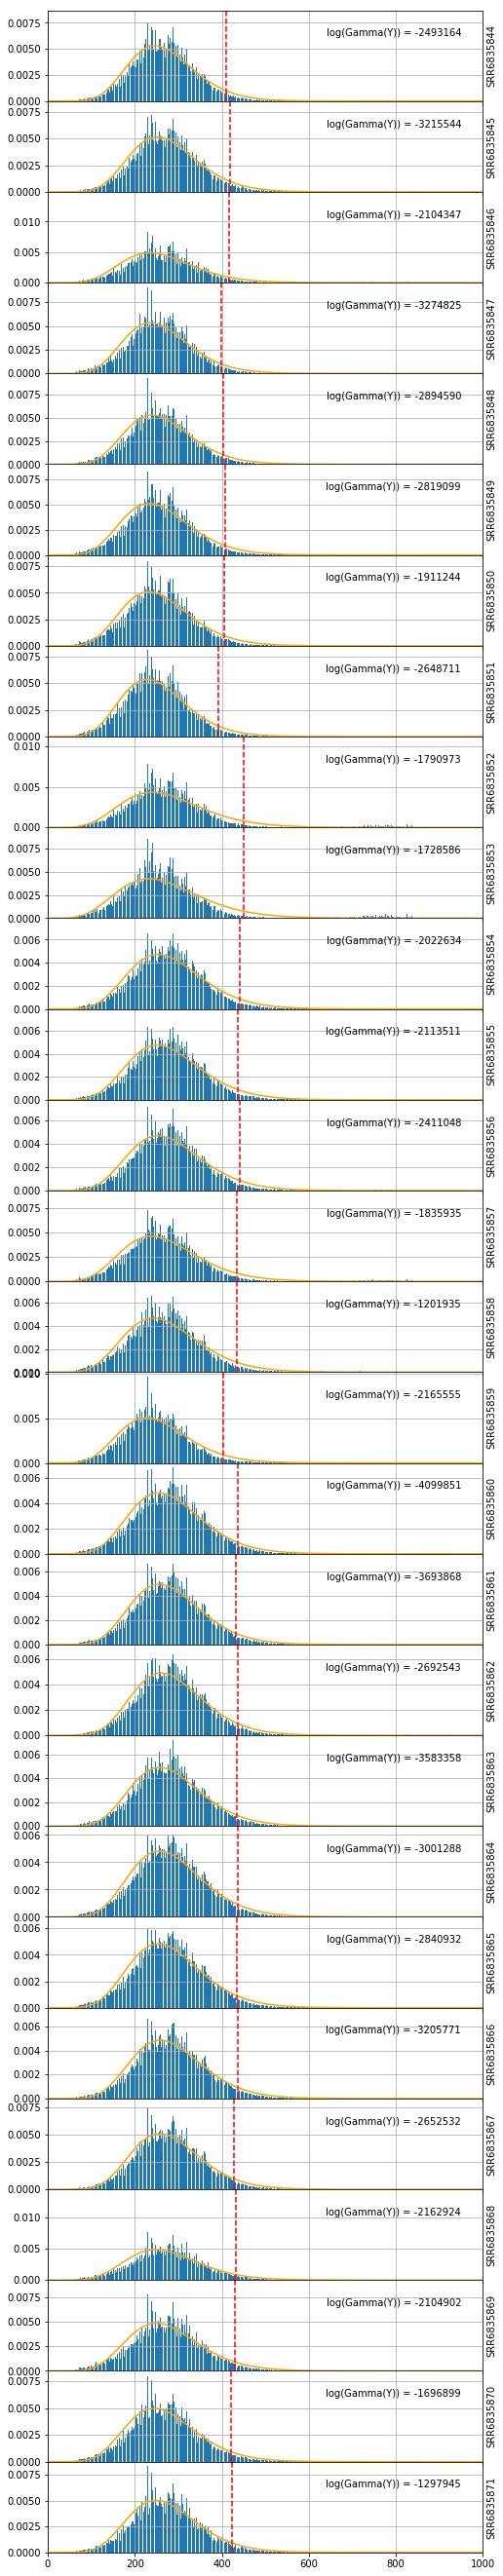

In [124]:
B = data_agg.batch.nunique()
X_plt = np.linspace(0,1000, 200)

f, axs = plt.subplots(B, figsize=(8, 48), sharex='col')
axs[0].set_xlim(left=0, right=1000)

for i in range(B):
    b = data_agg.batch.unique()[i]
    d_b = data_agg.loc[data_agg.batch == b, :]
    axs[i].bar(x=d_b.distance, height=d_b.counts/d_b.counts.sum())
    
    # Fitted Gamma
    a, scale = gamma_reparam(mu_all_hat_full + beta_hat_full[i], sigma_all_hat_full + alpha_hat_full[i])
    Y_plt = stats.gamma(a=a, scale=scale).pdf(X_plt)
    axs[i].plot(X_plt, Y_plt, color='orange')
    
    loglik_gamma = d_b.counts.dot(stats.gamma(a=a, scale=scale).logpdf(d_b.distance))
    axs[i].text(0.95, 0.80, "log(Gamma(Y)) = %d" % loglik_gamma, 
                verticalalignment='top', horizontalalignment='right', 
                transform=axs[i].transAxes)
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
    axs[i].set(ylabel=b)
    axs[i].yaxis.set_label_position("right")
    axs[i].grid(True)

f.subplots_adjust(hspace=0)
plt.show()